# Résolution de l'EDO avec Python

Une simulation de la dynamique faune-eau-végétation basée sur les EDO.

## Importation des packages

In [33]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Calibration des données 

In [56]:
# 1. Définition des paramètres (tes données)
P = 1000          # Pluie (mm/an)
alpha = 0.87      # ET/P
iota = 0.039      # Infiltration/P
rho = 0.045       # Ruissellement/P

rv = 0.0005       # Régénération végétale (trop faible !)
f = 0.0371        # Feux
d = 0.0021        # Déforestation

rn = 0.0678       # Natalité buffles
m = 0.0273        # Mortalité naturelle
p = 0.075         # Braconnage

cv = 75*1e-6         # Conso eau végétation
cn = 12.77*1e-6       # Conso eau buffles (35L/j converti en m3/an)
ch = 3.65*1e-2        # Conso herbe buffle

# Coefficients de calibration
beta = 0.5        # Efficience Eau -> Biomasse
gamma = 0.1       # Efficience Biomasse -> Population

## Formalisation de l'EDO

In [57]:
# 2. Le Système d'EDO
def pendjari_system(t, y, p_rate, f_rate):
    W, V, N = y
    
    # Équation Eau : dW/dt
    dWdt = P - (alpha*P + iota*P + rho*P) - cv*V - cn*N
    
    # Équation Buffles : dN/dt
    KN = gamma * max(V, 0.1)
    dNdt = rn * N * (1 - N/KN) - (m + p_rate) * N

    # Équation Végétation : dV/dt
    KV = beta * max(W, 0.1)
    dVdt = rv * V * (1 - V/KV) - (f_rate + d) * V - (ch*N)
    
    return [dWdt, dVdt, dNdt]

## Simulation avec scénario tendanciel et plan d'adaptation

In [ ]:
# 3. Simulation
t = np.linspace(0, 50, 10) # Simulation sur 50 ans
y0 = [41760, 47114, 20439]            # Conditions initiales (W, V, N)

# Scénario A : Actuel (p = 0.075)
sol_actuel = solve_ivp(pendjari_system, [t[0], t[-1]], y0, args=(p, f), method='Radau', t_eval = t)

# Scénario B : Conservation (p réduit à 0.02, feux réduits et r_v augmenté artificiellement)
rv = 0.05 
sol_sauvetage = solve_ivp(pendjari_system, [t[0], t[-1]], y0, args=(0.02, 0.01), method='Radau', t_eval = t)

## Visualisation des résultats

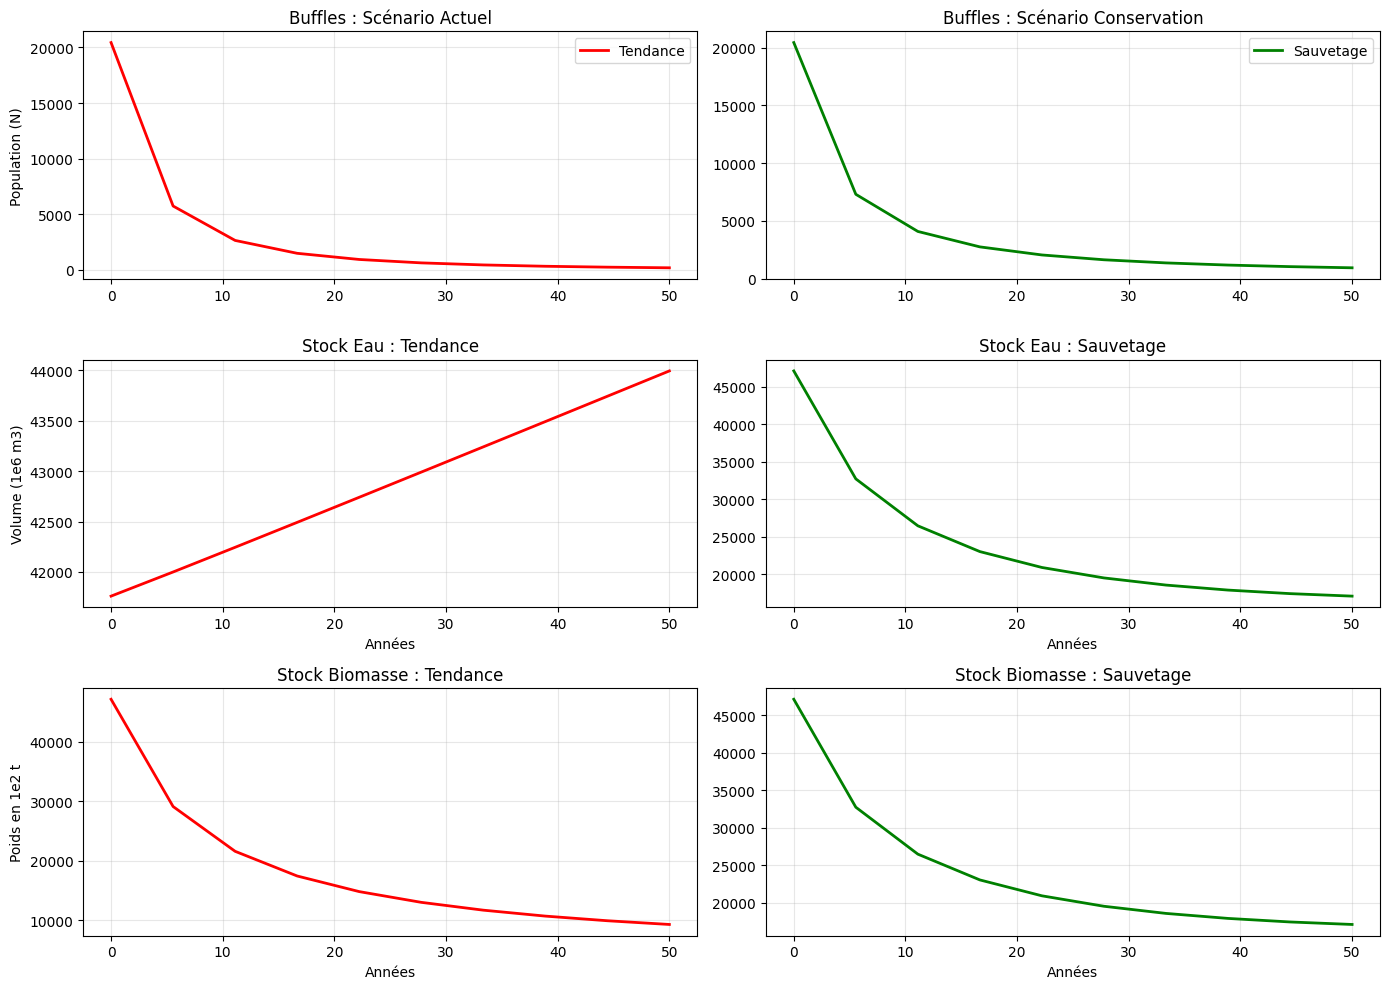

In [75]:
# On crée une figure avec une grille de 2 lignes et 2 colonnes
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# --- LIGNE 1 : LES BUFFLES ---
# Sous-intrigue 1 : Tendance
axes[0, 0].plot(sol_actuel.t, sol_actuel.y[2], 'r', lw=2, label='Tendance')
axes[0, 0].set_title('Buffles : Scénario Actuel')
axes[0, 0].set_ylabel('Population (N)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Sous-intrigue 2 : Sauvetage
axes[0, 1].plot(sol_sauvetage.t, sol_sauvetage.y[2], 'g', lw=2, label='Sauvetage')
axes[0, 1].set_title('Buffles : Scénario Conservation')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# --- LIGNE 2 : L'EAU ---
# Sous-intrigue 3 : Eau Tendance
axes[1, 0].plot(sol_actuel.t, sol_actuel.y[0], 'r', lw=2)
axes[1, 0].set_title('Stock Eau : Tendance')
axes[1, 0].set_ylabel('Volume (1e6 m3)')
axes[1, 0].set_xlabel('Années')
axes[1, 0].grid(True, alpha=0.3)

# Sous-intrigue 4 : Eau Sauvetage
axes[1, 1].plot(sol_sauvetage.t, sol_sauvetage.y[1], 'g', lw=2)
axes[1, 1].set_title('Stock Eau : Sauvetage')
axes[1, 1].set_xlabel('Années')
axes[1, 1].grid(True, alpha=0.3)

## --- BIOMASSE -----
# Sous-intrigue 3 : Biomasse Tendance
axes[2, 0].plot(sol_actuel.t, sol_actuel.y[1], 'r', lw=2)
axes[2, 0].set_title('Stock Biomasse : Tendance')
axes[2, 0].set_ylabel('Poids en 1e2 t')
axes[2, 0].set_xlabel('Années')
axes[2, 0].grid(True, alpha=0.3)

# Sous-intrigue 4 : Biomasse Sauvetage
axes[2, 1].plot(sol_sauvetage.t, sol_sauvetage.y[1], 'g', lw=2)
axes[2, 1].set_title('Stock Biomasse : Sauvetage')
axes[2, 1].set_xlabel('Années')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Graphique d'intervention

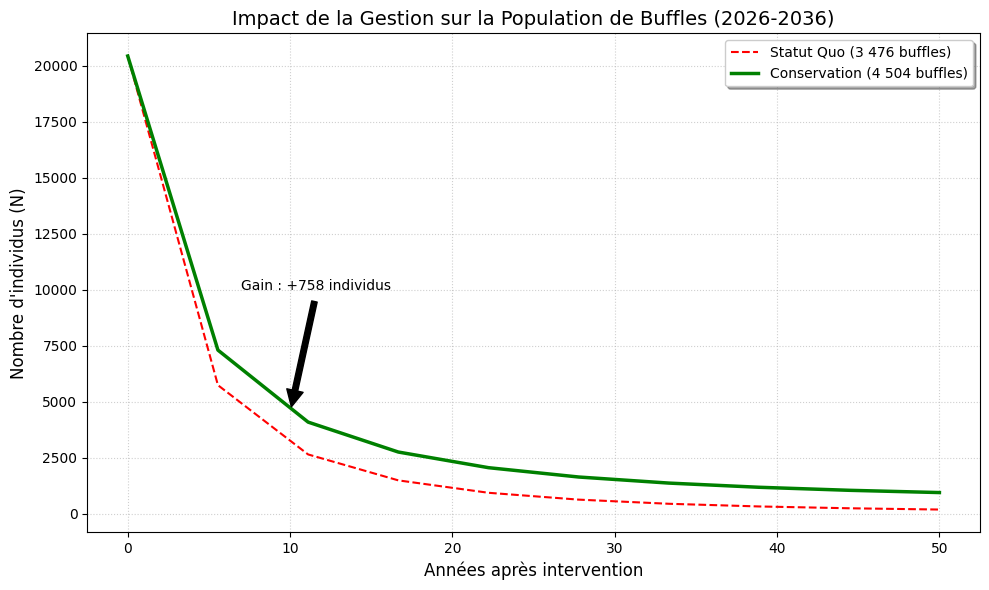

In [76]:
import matplotlib.pyplot as plt

# Création de la figure finale
plt.figure(figsize=(10, 6))

# Tracé des deux scénarios pour les Buffles
plt.plot(sol_actuel.t, sol_actuel.y[2], 'r--', label='Statut Quo (3 476 buffles)')
plt.plot(sol_sauvetage.t, sol_sauvetage.y[2], 'g-', linewidth=2.5, label='Conservation (4 504 buffles)')

# Mise en forme
plt.title('Impact de la Gestion sur la Population de Buffles (2026-2036)', fontsize=14)
plt.xlabel('Années après intervention', fontsize=12)
plt.ylabel('Nombre d\'individus (N)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(frameon=True, shadow=True)

# Annotation du gain
gain = int(sol_sauvetage.y[2][-1] - sol_actuel.y[2][-1])
plt.annotate(f'Gain : +{gain} individus', xy=(10, 4500), xytext=(7, 10000),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()